In [16]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import collections
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from collections import defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support


In [2]:
#sim
#Upload faulty training dataset
df = pd.read_csv('/Users/mansimran/TEP_Faulty_Training.csv', on_bad_lines='skip')

#Upload the fault-free training dataset
df2 = pd.read_csv('/Users/mansimran/TEP_FaultFree_Training.csv', on_bad_lines='skip')

#Upload the faulty testing dataset
df_test = pd.read_csv('/Users/mansimran/TEP_Faulty_Testing.csv', on_bad_lines='skip')

#Upload the fault-free training dataset
df2_test = pd.read_csv('/Users/mansimran/TEP_FaultFree_Testing.csv', on_bad_lines='skip')

In [3]:
#thomas
# Upload faulty training dataset
df = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_Faulty_Training.csv', on_bad_lines='skip')

# Upload the fault-free training dataset
df2 = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_FaultFree_Training.csv', on_bad_lines='skip')

# Upload the faulty testing dataset
df_test = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_Faulty_Testing.csv', on_bad_lines='skip')

# Upload the fault-free training dataset
df2_test = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_FaultFree_Testing.csv', on_bad_lines='skip')

In [4]:
#Sub-sample
df = df.loc[(df['simulationRun']<51),:]
#df2 = df2.loc[(df2['simulationRun']<51),:]

df_test = df_test.loc[(df_test['simulationRun']<41),:]
df2_test = df2_test.loc[(df2_test['simulationRun']<201),:]

In [5]:
#Combine Test data
combined_df_test = pd.concat([df_test, df2_test], ignore_index=True)

#Combine Training data
combined_df = pd.concat([df, df2], ignore_index=True)

In [10]:
#These are the features that I remove based on EDA - EDA file seperate
#add in EDA here
features_to_plot = ['xmeas_2','xmeas_5', 'xmeas_12', 'xmeas_14', 'xmeas_15', 'xmeas_17', 'xmeas_37','xmv_7', 'xmv_8']

def featureengg(combined_df, features_to_plot):

    # Assuming combined_df, features_to_plot are defined earlier
    clean_df = combined_df.drop(columns=features_to_plot).copy()

    window_size = 20  #Window size
    j = [2, 4, 6, 8]  # Lag intervals

    new_columns = defaultdict(list)

    # Loop through faults and runs
    for fault in clean_df['faultNumber'].unique():
        for run in clean_df[clean_df['faultNumber'] == fault]['simulationRun'].unique():
            mask = (clean_df['faultNumber'] == fault) & (clean_df['simulationRun'] == run)

            for feature in clean_df.columns.difference(['faultNumber', 'simulationRun', 'sample']):
                frequency_feat = [np.nan] * len(clean_df.loc[mask, feature])
                feature_ma = f'{feature}_MA'
                feature_std = f'{feature}_STD'

                # Calculate moving average and standard deviation
                ma = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).mean()
                std = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).std()


                new_columns[feature_ma].extend(ma)
                new_columns[feature_std].extend(std)

                # Calculate and store lagged features
                for i in j:
                    lag_name = f'{feature}_lag{i}'
                    lag = clean_df.loc[mask, feature].shift(i)
                    new_columns[lag_name].extend(lag)

                #Calculate the FFT
                feature_f = f'{feature}_frequency'
                for i in range(len(clean_df.loc[mask, feature])):
                    if i < window_size:
                        frequency_feat[i] = np.nan
                    else:
                        frequency_feat[i] = np.abs(np.fft.fft(clean_df.loc[mask, feature][i-window_size:i])[1:]).max()

                new_columns[feature_f].extend(frequency_feat)

    for key in new_columns:
        new_columns[key] = pd.Series(new_columns[key], index=clean_df.index)

    new_columns_df = pd.DataFrame(new_columns)
    clean_df = pd.concat([clean_df, new_columns_df], axis=1)
    return clean_df

In [11]:
#Feature engineering of Training Data
clean_df = featureengg(combined_df, features_to_plot)

#For Binary classification
clean_df_cleaned = clean_df.dropna(axis=0)
clean_df_cleaned['faultNumber'] = (clean_df_cleaned['faultNumber'] > 0).astype(int)
comb_x_df = clean_df_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df = clean_df_cleaned['faultNumber']

#For Multi Classification
clean_df_cleaned = clean_df.dropna(axis=0)
comb_x_df2 = clean_df_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df2 = clean_df_cleaned['faultNumber']



C:\Users\kamin\AppData\Local\Temp\ipykernel_19628\3904109653.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_cleaned['faultNumber'] = (clean_df_cleaned['faultNumber'] > 0).astype(int)


In [13]:
#Feature engineering of Testing Data
clean_df_test = featureengg(combined_df_test, features_to_plot)

#For Binary classification
clean_df_test_cleaned = clean_df_test.dropna(axis=0)
clean_df_test_cleaned['faultNumber'] = (clean_df_test_cleaned['faultNumber'] > 0).astype(int)
comb_x_df_test = clean_df_test_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df_test = clean_df_test_cleaned['faultNumber']

#For Multi classification
clean_df_test_cleaned = clean_df_test.dropna(axis=0)
comb_x_df_test2 = clean_df_test_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df_test2 = clean_df_test_cleaned['faultNumber']


C:\Users\kamin\AppData\Local\Temp\ipykernel_19628\2965435764.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_test_cleaned['faultNumber'] = (clean_df_test_cleaned['faultNumber'] > 0).astype(int)


In [14]:
#For Binary classification

A1 = Pipeline([('A_',StandardScaler(with_mean=False))])
clf = RandomForestClassifier(n_estimators=200, max_depth=40)

full_pipeline_Kbest = Pipeline([('initial_transform', A1), ('RFR', clf)])
X_new=full_pipeline_Kbest.fit(comb_x_df, comb_y_df)

Accuracy: 0.957355


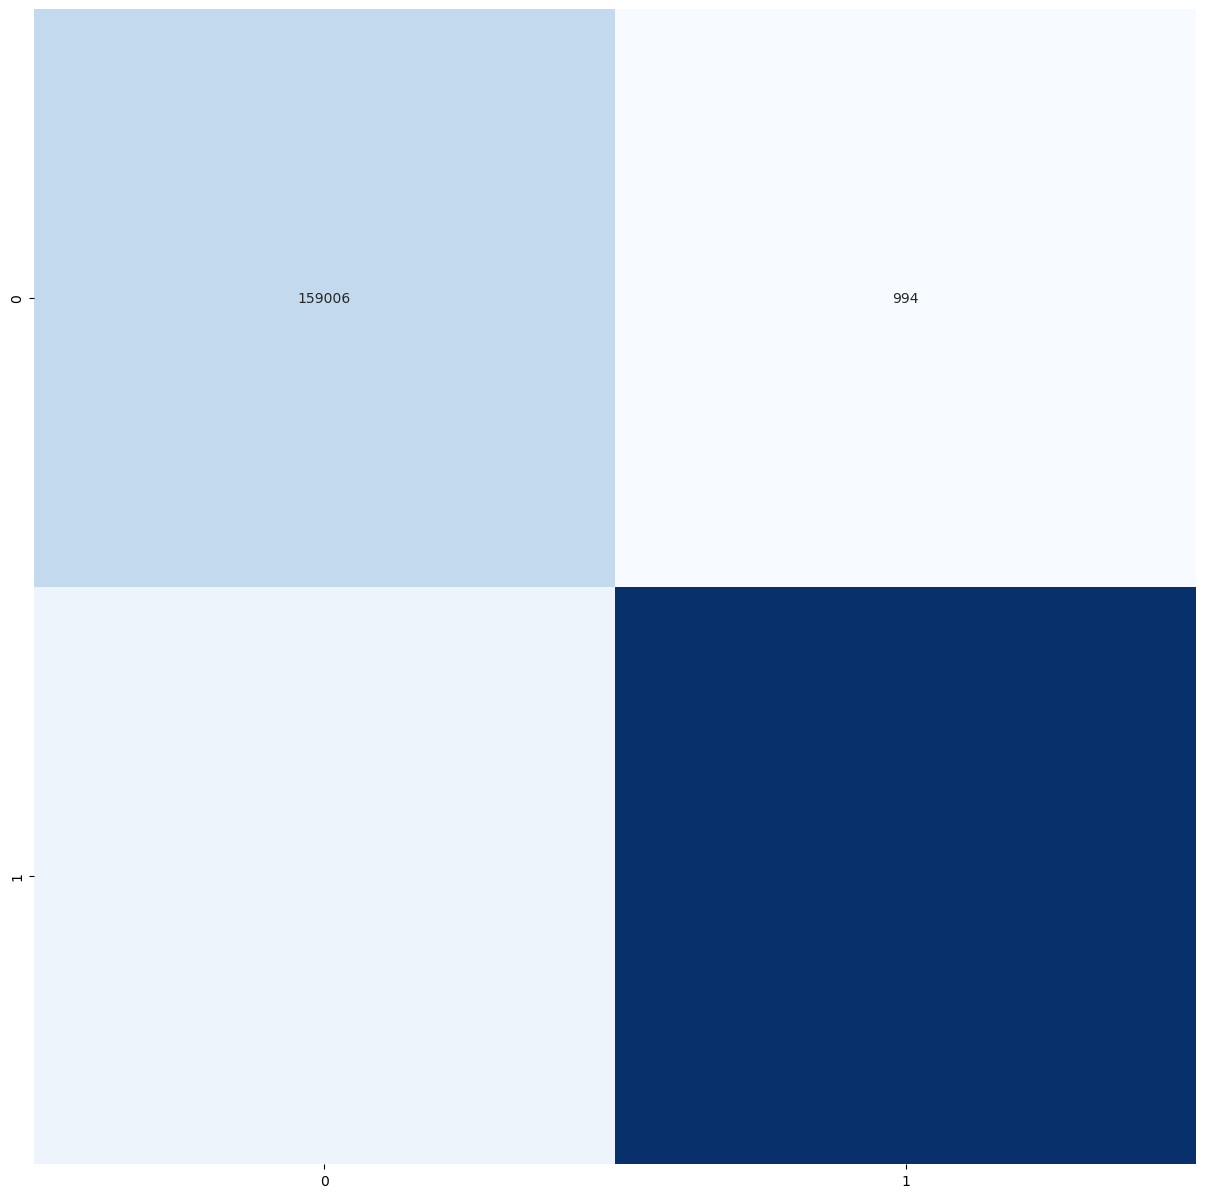

Precision: 0.9590327124070267
Recall: 0.9566138297872341
F1-Score: 0.957056639229158
Accuracy: 0.9566138297872341
        Actual  Predicted  Correct  sample  simulationRun
20           0          0    False      21              1
21           0          0    False      22              1
22           0          0    False      23              1
23           0          0    False      24              1
24           0          0    False      25              1
...        ...        ...      ...     ...            ...
959995       0          0     True     956            200
959996       0          0     True     957            200
959997       0          0     True     958            200
959998       0          0     True     959            200
959999       0          0     True     960            200

[940000 rows x 5 columns]


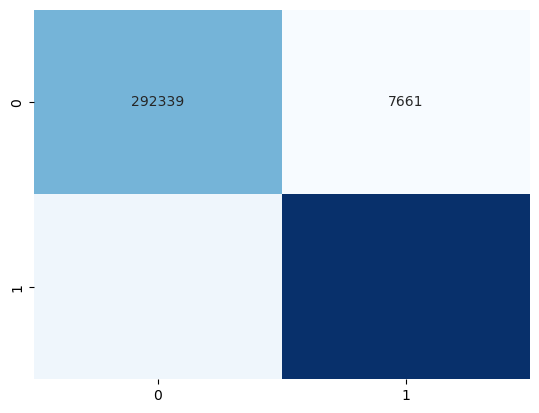

In [17]:
#Results for binary model
predictions = full_pipeline_Kbest.predict(comb_x_df_test)
results_df = pd.DataFrame({
    'Actual': comb_y_df_test,
    'Predicted': predictions,
    'Correct': comb_y_df_test == predictions,
})


results_df['sample'] = clean_df_test_cleaned['sample']
results_df['simulationRun'] = clean_df_test_cleaned['simulationRun']

plt.figure(figsize=(15, 15))
conf_matrix = confusion_matrix(results_df.loc[results_df['sample']>160,'Actual'],
                               results_df.loc[results_df['sample']>160,'Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

accuracy = accuracy_score(results_df.loc[results_df['sample']>160,'Actual'],
                               results_df.loc[results_df['sample']>160,'Predicted'])
print(f"Accuracy: {accuracy}")

plt.show()
anotherone = results_df.loc[results_df['sample']>160].groupby(['Actual']).agg({'Predicted':'count', 'Correct':'sum'})
anotherone['accuracy'] = anotherone['Correct']/anotherone['Predicted']

results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
conf_matrix =confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
precision, recall, f1, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

# Accuracy
accuracy = accuracy_score(results_df['Actual'], results_df['Predicted'])
print(f"Accuracy: {accuracy}")

anotherone = results_df.loc[results_df['sample']>160].groupby(['Actual']).agg({'Predicted':'count', 'Correct':'sum'})
anotherone['accuracy'] = anotherone['Correct']/anotherone['Predicted']

print(results_df)

Precision: 0.9590327124070267
Recall: 0.9566138297872341
F1-Score: 0.957056639229158
Accuracy: 0.9566138297872341


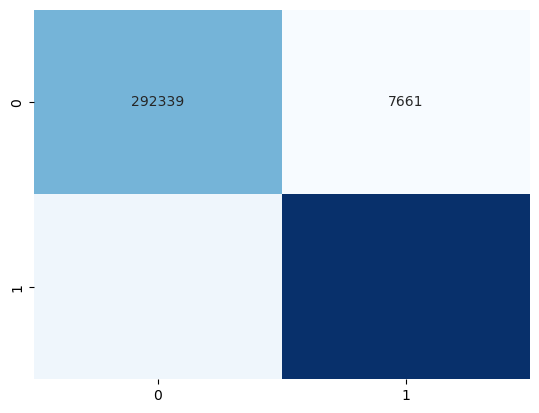

In [18]:
#More results for binary model
results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
conf_matrix =confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
precision, recall, f1, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

# Accuracy
accuracy = accuracy_score(results_df['Actual'], results_df['Predicted'])
print(f"Accuracy: {accuracy}")

In [19]:
#Predict Training Data, and use this for training of Multi-classification
New_predict=full_pipeline_Kbest.predict(comb_x_df)
clean_df_cleaned['Result'] = New_predict

New_predict_test=full_pipeline_Kbest.predict(comb_x_df_test)
clean_df_test_cleaned['Result'] = New_predict_test

smaller = clean_df_cleaned.loc[clean_df_cleaned['Result']==1]
smaller.drop(columns='Result',inplace=True)
my_classifierx = smaller.drop(columns=['faultNumber','simulationRun','sample'])
my_classifiery = smaller['faultNumber']

smaller_test = clean_df_test_cleaned.loc[clean_df_test_cleaned['Result']==1]
smaller_test.drop(columns='Result',inplace=True)
smaller_test.loc[smaller_test['sample'] < 161, 'faultNumber'] = 0
my_testx = smaller_test.drop(columns=['faultNumber','simulationRun','sample'])
my_testy = smaller_test['faultNumber']

C:\Users\kamin\AppData\Local\Temp\ipykernel_19628\3340179158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_cleaned['Result'] = New_predict
C:\Users\kamin\AppData\Local\Temp\ipykernel_19628\3340179158.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_test_cleaned['Result'] = New_predict_test
C:\Users\kamin\AppData\Local\Temp\ipykernel_19628\3340179158.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [20]:
#For Multiclassification

A1 = Pipeline([('A_',StandardScaler(with_mean=False))])

clf = RandomForestClassifier(n_estimators=200, max_depth=40)

full_pipeline_Kbest2 = Pipeline([('initial_transform', A1), ('RFR', clf)])


X_new2=full_pipeline_Kbest2.fit(my_classifierx, my_classifiery)


In [21]:
#Results for Multi classification
predictions = full_pipeline_Kbest2.predict(my_testx)

results_df = pd.DataFrame({
    'Actual': comb_y_df_test2,
    'Predicted': predictions,
    'Correct': comb_y_df_test == predictions,
})
results_df['sample'] = clean_df_test_cleaned['sample']
results_df['Predicted'].loc[results_df['Predicted']==1]=predictions2

results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']



# Assuming y_true contains the true labels and y_pred contains your model predictions
print(classification_report(results_df['Actual'], results_df['Predicted']))


ValueError: ('Lengths must match to compare', (940000,), (614539,))

<Axes: >

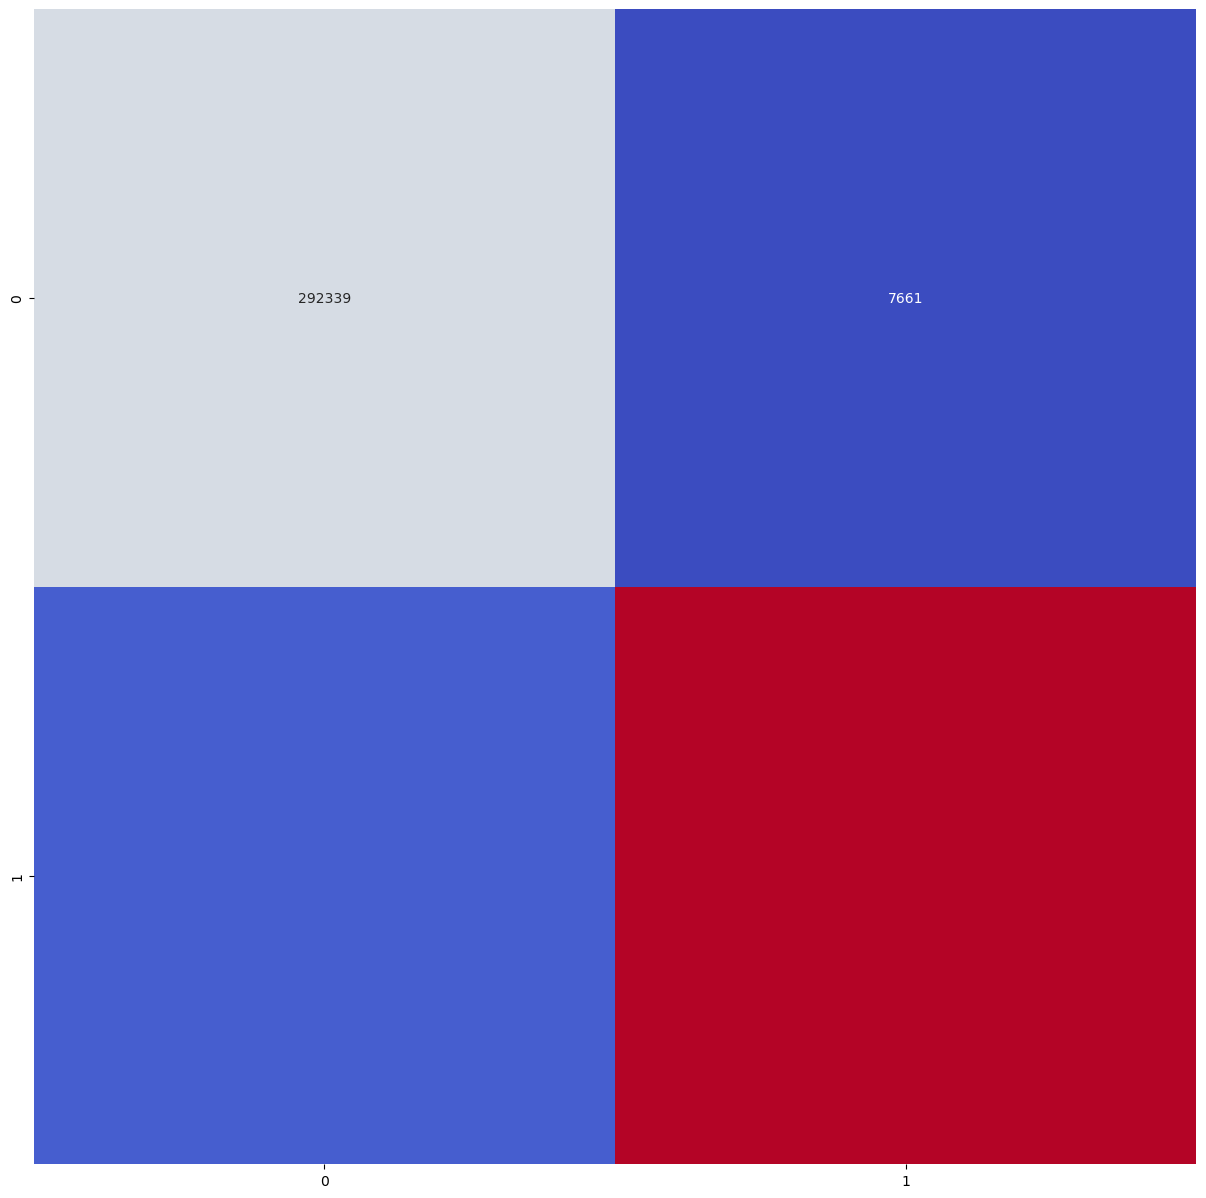

In [22]:
#Results for multiclassification 

plt.figure(figsize=(15, 15))
conf_matrix = confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', cbar=False)

        0_ratio  1_ratio
sample                  
21        0.238      NaN
22        0.221      NaN
23        0.219      NaN
24        0.219      NaN
25        0.219      NaN
...         ...      ...
956       1.000  0.94875
957       1.000  0.95000
958       1.000  0.94875
959       1.000  0.94875
960       0.995  0.94875

[940 rows x 2 columns]


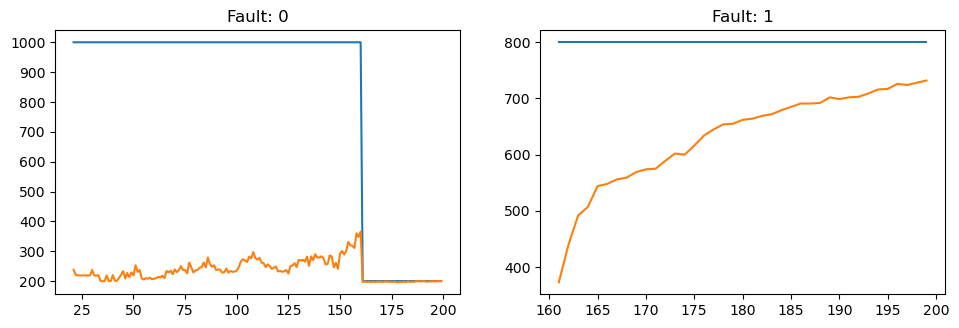

In [23]:
#Results for multi classification
results_ratio_dict = {}
plt.figure(figsize=(24, 24))
for fault in results_df['Actual'].unique():
    plt.subplot(6,4,fault+1)
    one_one = results_df.loc[(results_df['Actual']==fault) & (results_df['sample']<200)].groupby(['sample']).count()
    plt.plot(one_one['Actual'])
    tne_one = results_df.loc[(results_df['Actual']==fault) & (results_df['sample']<200)].groupby(['sample']).sum()
    plt.plot(tne_one['Correct'])
    plt.title(f'Fault: {fault}')
    sums = results_df.loc[results_df['Actual'] == fault].groupby('sample')['Correct'].sum()
    
    # Count the occurrences of each 'Sample' within the current fault
    counts = results_df.loc[results_df['Actual'] == fault].groupby('sample').size()
    
    # Calculate the ratio (sum/count) and store it in the dictionary
    ratio = sums / counts
    results_ratio_dict[f'{fault}_ratio'] = ratio

# Convert the dictionary into a DataFrame
results_ratio_df = pd.DataFrame(results_ratio_dict)

print(results_ratio_df)

Precision: 0.9602015365294543
Recall: 0.957522340425532
F1-Score: 0.9579833881033678
Accuracy: 0.957522340425532


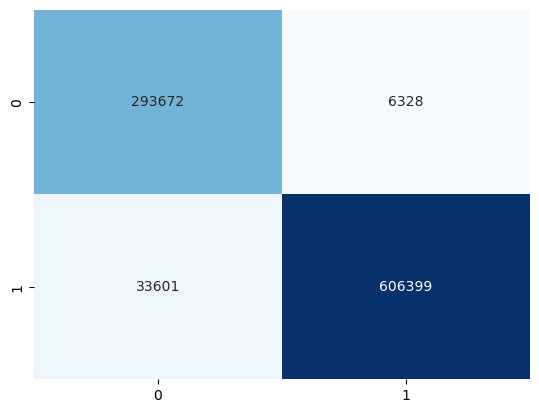